In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

# 1. 读取 order_products__prior.csv (订单详情表)
prior = pd.read_csv("../day14/data/instacart/order_products__prior.csv")

# 2. 读取 products.csv (产品表)
products = pd.read_csv("../day14/data/instacart/products.csv")

# 3. 读取 orders.csv (订单表)
orders = pd.read_csv("../day14/data/instacart/orders.csv")

# 4. 读取 aisles.csv (过道表)
aisles = pd.read_csv("../day14/data/instacart/aisles.csv")

# --- 预处理：清洗列名（防止有空格报错） ---
prior.columns = prior.columns.str.strip()
products.columns = products.columns.str.strip()
orders.columns = orders.columns.str.strip()
aisles.columns = aisles.columns.str.strip()

# --- 开始合并 ---
print("正在合并数据...")
# 1. prior + products
_mg = pd.merge(prior, products, on='product_id')

# 2. + orders (现在 orders 表里应该有 order_id 了)
_mg = pd.merge(_mg, orders, on='order_id')

# 3. + aisles
mt = pd.merge(_mg, aisles, on='aisle_id')

print("合并成功！")
print(mt.head())

正在合并数据...
合并成功！
   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id  user_id eval_set  order_number  order_dow  \
0        86             16   202279    prior             3          5   
1        83              4   202279    prior             3          5   
2       104             13   202279    prior             3          5   
3        19             13   202279    prior             3          5   
4        17             13   202279    prior             3          5   

   order_hour_of_day  days_since_prior_order               aisle

In [11]:
mt.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients


In [12]:
mt.shape

(32434489, 14)

In [13]:
mt.isnull().sum() / mt.shape[0]  #数据缺失率，没有缺失值

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    0.06407
aisle                     0.00000
dtype: float64

In [14]:
# 交叉表（特殊的分组工具），如果在这一步内存不够了，重启一下jupyter，还是不行，筛选一部分用户的数据，进行聚类
cross = pd.crosstab(mt['user_id'], mt['aisle'])

# 查看前10行
print(cross.head(10))

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             0            2                 0   
6                             0            0                 0   
7                             0            0                 0   
8                             0            1                 0   
9                             0            0                 0   
10                            0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2  

In [15]:
cross.shape

(206209, 134)

In [19]:
# --- 1. 进行主成分分析 (PCA) ---
# n_components=0.9 表示：我们要保留原始数据 90% 的信息量（方差）
# 系统会自动计算需要多少个特征才能达到这个 90% 的标准
# pca = PCA(n_components=0.9)
#
# # --- 2. 训练并转换数据 ---
# # fit_transform：既训练模型，又将 cross 表转换成降维后的数据
# data = pca.fit_transform(cross)
#
# # 查看降维后的形状
# # 预期结果：行数（用户数）不变，列数从 134 减少到约 27 (如截图所示)
# print("降维后的形状:", data.shape)
# print("数据类型:", type(data))

# --- 3. 截取部分样本 ---
# 把样本数量减少，为了下面画图方便（跑全量数据画图会很慢或卡死）
# 这里只取前 500 个用户的数据赋值给 x
x = data[:500]

# 查看截取后的形状
print("截取后的形状:", x.shape)

# 查看前 10 行数据
print(x[0:10])

截取后的形状: (500, 27)
[[-2.42156587e+01 -2.42942720e+00 -2.46636975e+00  1.45686388e-01
   2.69042476e-01 -1.43293209e+00 -2.14067666e+00  2.73803122e+00
  -2.71431623e+00 -1.74313529e+00 -1.13632718e+00  6.73601069e-01
  -1.65070735e+00  2.83802486e+00  5.89384489e+00 -7.84312891e+00
  -4.84010146e+00 -3.22598697e+00 -4.58007571e+00  7.77403349e-01
  -3.69912893e+00  1.90721439e+00 -2.99538594e+00 -7.72922878e-01
   6.86800336e-01  1.69439402e+00 -2.34323022e+00]
 [ 6.46320806e+00 -3.67511165e+01  8.38255336e+00 -1.50975303e+01
  -6.92093785e+00 -9.78375183e-01 -6.01156653e+00 -3.78772465e+00
  -8.18074883e+00 -9.04086141e+00 -5.61352902e+00 -1.11325323e+00
   2.96702911e+00 -4.73123497e+00 -9.11472283e+00 -2.14709471e-01
   1.29694031e+00 -7.37605505e-01 -7.37401979e-01  7.40042249e-01
  -9.13382968e-02  5.15128465e+00  4.58481528e+00  3.23789431e+00
   4.12121252e+00  2.44689740e+00 -4.28348478e+00]
 [-7.99030162e+00 -2.40438257e+00 -1.10300641e+01 -6.72230096e-01
  -4.42368029e-01 -2.8

In [20]:
# --- 1. 进行主成分分析 (PCA) ---
# n_components=0.9 表示：我们要保留原始数据 90% 的信息量（方差）
# 系统会自动计算需要多少个特征才能达到这个 90% 的标准
pca = PCA(n_components=0.9)

# --- 2. 训练并转换数据 ---
# fit_transform：既训练模型，又将 cross 表转换成降维后的数据
data = pca.fit_transform(cross)

# 查看降维后的形状
# 预期结果：行数（用户数）不变，列数从 134 减少到约 27 (如截图所示)
print("降维后的形状:", data.shape)
print("数据类型:", type(data))

# --- 3. 截取部分样本 ---
# 把样本数量减少，为了下面画图方便（跑全量数据画图会很慢或卡死）
# 这里只取前 500 个用户的数据赋值给 x
# x = data[:500]
x=data
# 查看截取后的形状
print("截取后的形状:", x.shape)

# 查看前 10 行数据
print(x[0:10])

降维后的形状: (206209, 27)
数据类型: <class 'numpy.ndarray'>
截取后的形状: (206209, 27)
[[-2.42156587e+01 -2.42942720e+00 -2.46636975e+00  1.45686388e-01
   2.69042476e-01 -1.43293209e+00 -2.14067666e+00  2.73803122e+00
  -2.71431623e+00 -1.74313529e+00 -1.13632718e+00  6.73601069e-01
  -1.65070735e+00  2.83802486e+00  5.89384489e+00 -7.84312891e+00
  -4.84010146e+00 -3.22598697e+00 -4.58007571e+00  7.77403349e-01
  -3.69912893e+00  1.90721439e+00 -2.99538594e+00 -7.72922878e-01
   6.86800336e-01  1.69439402e+00 -2.34323022e+00]
 [ 6.46320806e+00 -3.67511165e+01  8.38255336e+00 -1.50975303e+01
  -6.92093785e+00 -9.78375183e-01 -6.01156653e+00 -3.78772465e+00
  -8.18074883e+00 -9.04086141e+00 -5.61352902e+00 -1.11325323e+00
   2.96702911e+00 -4.73123497e+00 -9.11472283e+00 -2.14709471e-01
   1.29694031e+00 -7.37605505e-01 -7.37401979e-01  7.40042249e-01
  -9.13382968e-02  5.15128465e+00  4.58481528e+00  3.23789431e+00
   4.12121252e+00  2.44689740e+00 -4.28348478e+00]
 [-7.99030162e+00 -2.40438257e+00 

In [21]:
# --- 1. 查看数据范围 (可选) ---
# 这一步是为了对数据分布有个大概了解
print("数据最大值:", x.max())
print("数据最小值:", x.min())

# --- 2. 构建 K-Means 聚类模型 ---
# 假设我们将用户分为 4 个类别 (这个数字 4 是超参数，可以根据需求调整)
km = KMeans(n_clusters=4)

# --- 3. 训练模型 ---
# 使用之前截取的数据 x (前500个样本) 进行训练
km.fit(x)

# --- 4. 进行预测 ---
# 预测每个样本属于哪个类别
predict = km.predict(x)

# --- 5. 查看结果 ---
# 输出是一个数组，里面的数字 (0, 1, 2, 3) 代表每个用户被分到的组别
print(predict)

数据最大值: 1004.143272345661
数据最小值: -887.2401228809231
[0 3 0 ... 3 1 0]


[0 1 2 3]


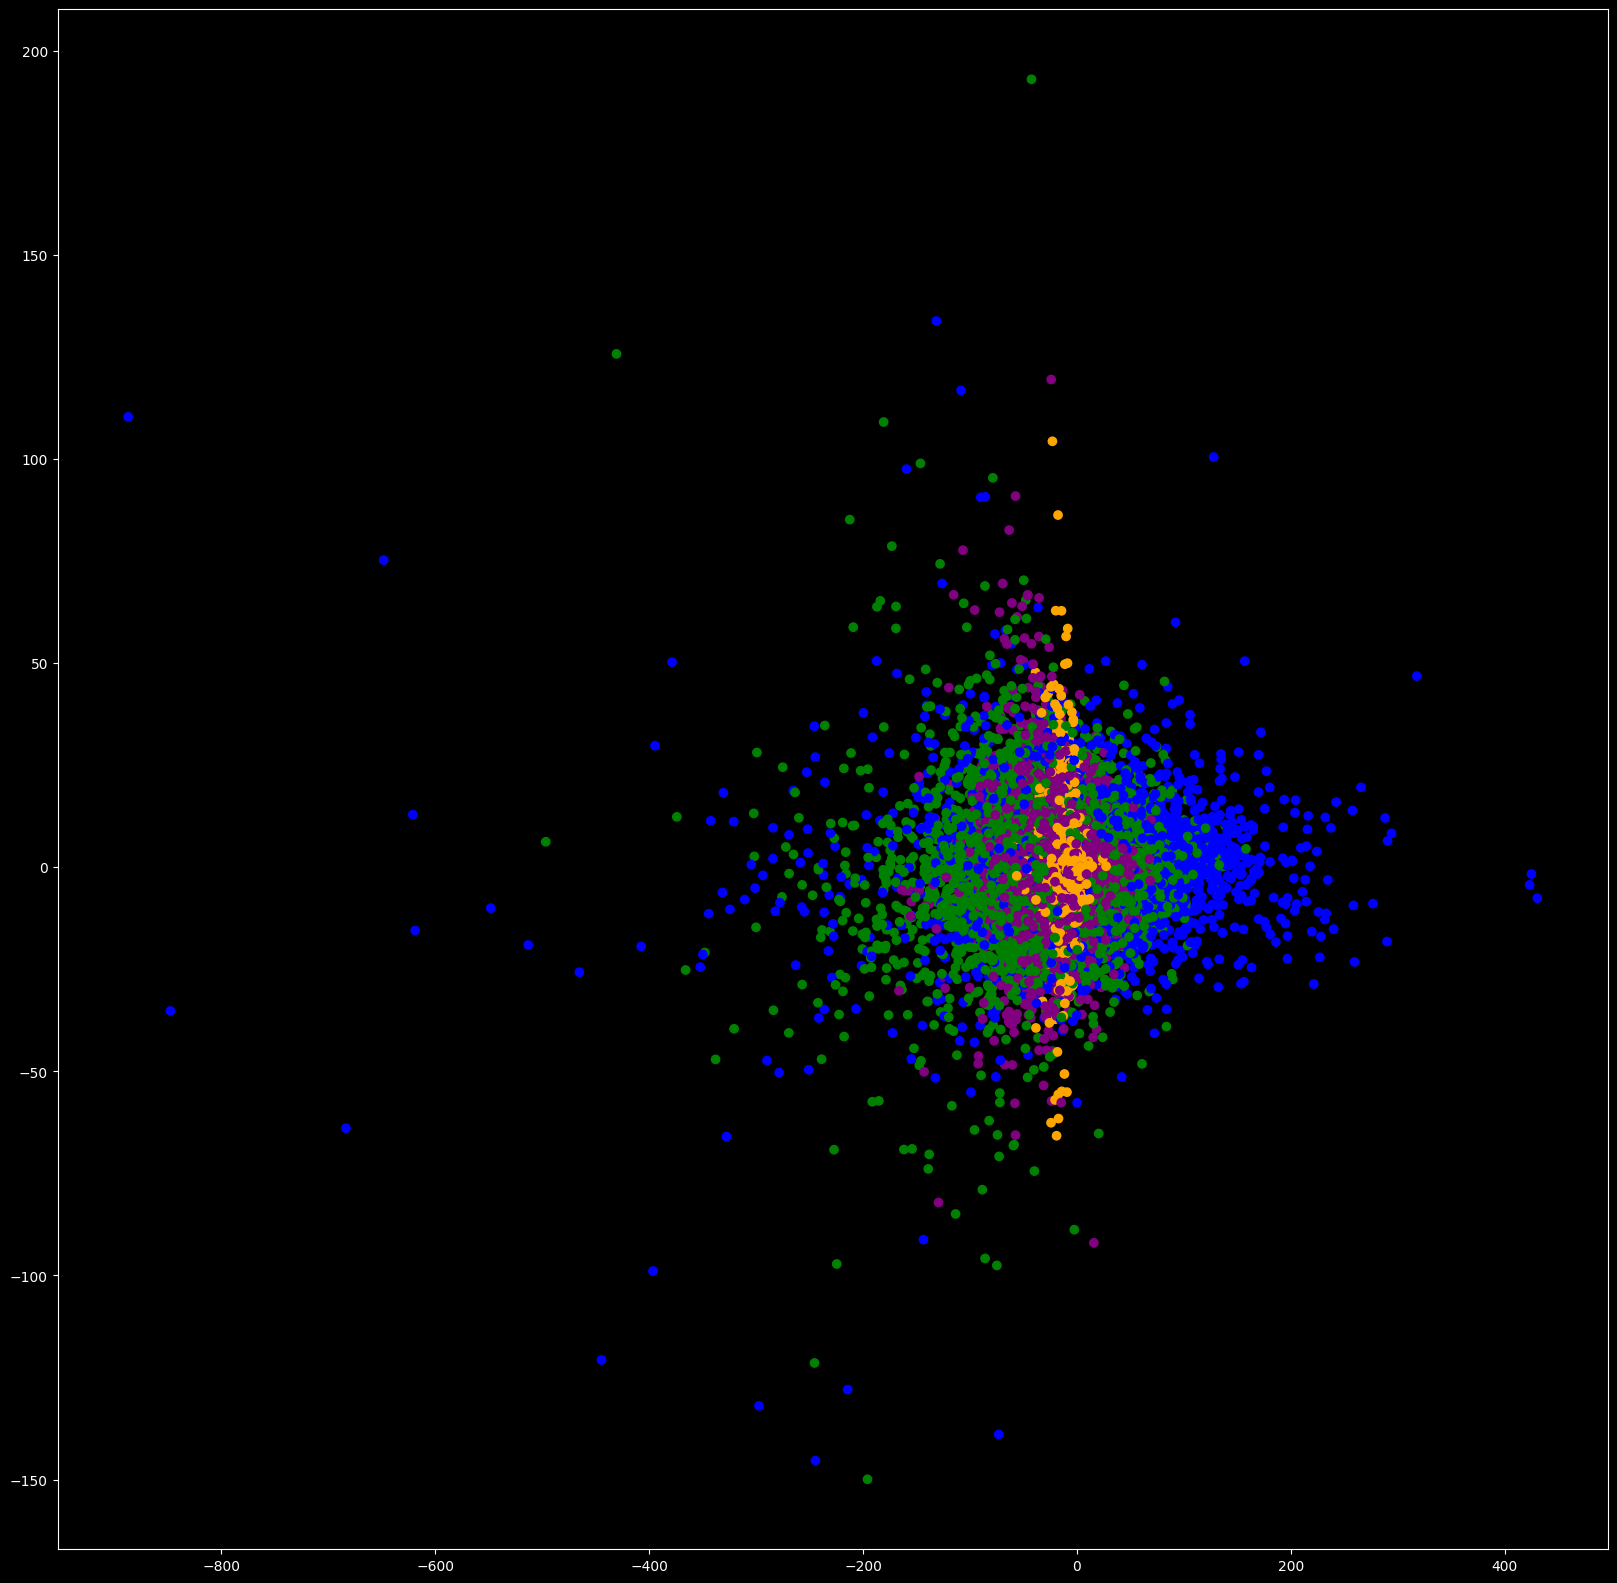

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 查看分类结果包含哪些类别
# 预期结果：array([0, 1, 2, 3])，表示一共分成了 4 类
print(np.unique(predict))

# 2. 设置绘图画布大小
plt.figure(figsize=(20, 20))

# 3. 定义颜色映射
# 建立四个颜色的列表，分别对应 0, 1, 2, 3 号类别
colored = ['orange', 'green', 'blue', 'purple']

# 4. 给每个样本匹配颜色
# 列表推导式：如果 predict[i] 是 0，就给它 'orange'，如果是 1 就给 'green'...
colr = [colored[i] for i in predict]

# 5. 绘制散点图 (Scatter Plot)
# x[:, 1]  代表所有样本的第 2 个特征 (X轴)
# x[:, 19] 代表所有样本的第 20 个特征 (Y轴)
# 这里的 1 和 19 是可以随意修改的，你可以试试改成其他数字看看效果
plt.scatter(x[:, 1], x[:, 19], color=colr)

# 显示图像
plt.show()

In [23]:
silhouette_score(x, predict)

0.4378010163649518

In [24]:

km = KMeans(n_clusters=10)

# 开始训练
km.fit(x)

# 获取预测结果
predict = km.predict(x)

# 打印轮廓系数 (Silhouette Score)
# 这个分数越高 (越接近 1)，说明聚类效果越好
print(silhouette_score(x, predict))

# 查看预测的类别标签
predict

0.2967938471545044


array([6, 0, 0, ..., 0, 4, 6], shape=(206209,), dtype=int32)